**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [7]:
import tensorflow as tf
import numpy as np
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [8]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [9]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [10]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

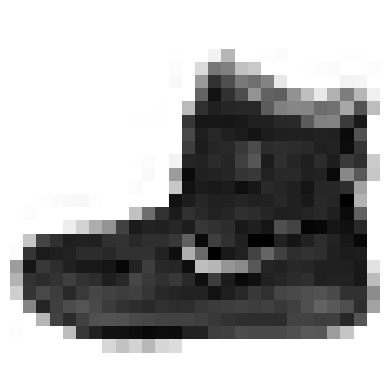

In [11]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [12]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [14]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

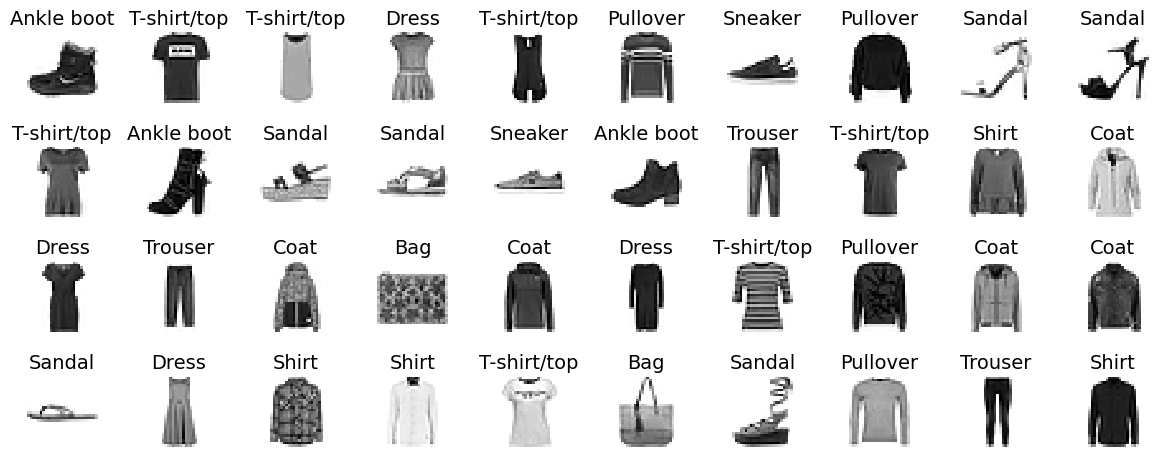

In [15]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Creating the model using the Sequential API

In [16]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [17]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


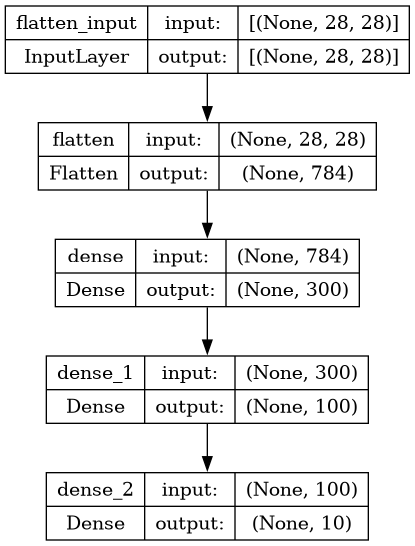

In [19]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [20]:
model.layers

In [21]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [22]:
model.get_layer('dense') is hidden1

True

In [23]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.0074715 ,  0.05478467,  0.06923167, ..., -0.07403305,
         0.06557092, -0.05296539],
       [ 0.04085714, -0.05618474, -0.02673753, ...,  0.0479294 ,
        -0.00048514,  0.01233411],
       [ 0.00430987, -0.0652684 ,  0.05977623, ...,  0.00171715,
         0.00075588, -0.01680348],
       ...,
       [-0.01490017,  0.04326889, -0.01121662, ..., -0.00920949,
         0.00279641, -0.06891057],
       [ 0.01110473, -0.07356387, -0.0683203 , ...,  0.02925357,
        -0.00652473, -0.02531389],
       [ 0.04966155,  0.06117716,  0.05782548, ..., -0.06887862,
        -0.06071955,  0.0247517 ]], dtype=float32)

In [24]:
weights.shape

(784, 300)

In [25]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [26]:
biases.shape

(300,)

### Compiling the model

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

### Training and evaluating the model

In [31]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7061 - accuracy: 0.7669 - val_loss: 0.5047 - val_accuracy: 0.8250
Epoch 2/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4854 - accuracy: 0.8315 - val_loss: 0.4615 - val_accuracy: 0.8326
Epoch 3/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4391 - accuracy: 0.8455 - val_loss: 0.4234 - val_accuracy: 0.8542
Epoch 4/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4138 - accuracy: 0.8551 - val_loss: 0.3940 - val_accuracy: 0.8614
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3935 - accuracy: 0.8625 - val_loss: 0.3931 - val_accuracy: 0.8594


In [32]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 1719}

In [33]:
print(history.epoch)

[0, 1, 2, 3, 4]


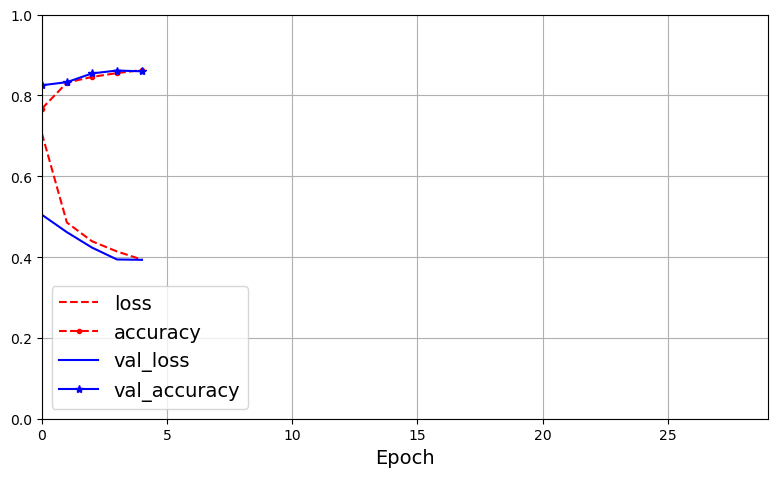

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

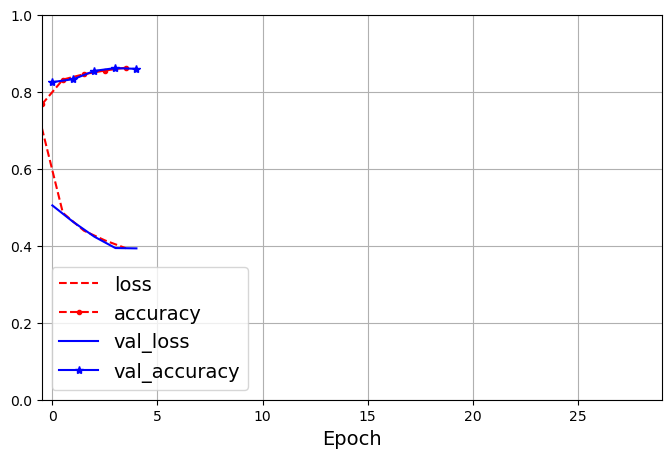

In [35]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [36]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.8465


[0.429119735956192, 0.8464999794960022]

### Using the model to make predictions

In [37]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 85ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.08, 0.  , 0.86],
       [0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [38]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [39]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [40]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

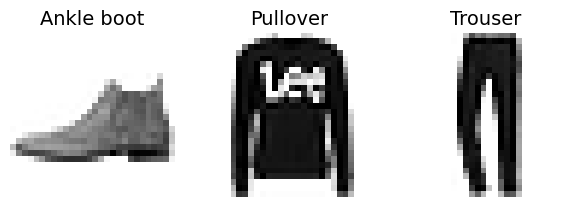

In [41]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [42]:
# extra code – load and split the California housing dataset, like earlier
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [43]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8666 - root_mean_squared_error: 0.9309 - val_loss: 0.3970 - val_root_mean_squared_error: 0.6301
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3790 - root_mean_squared_error: 0.6157 - val_loss: 1.4509 - val_root_mean_squared_error: 1.2045
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3715 - root_mean_squared_error: 0.6095 - val_loss: 0.3388 - val_root_mean_squared_error: 0.5821
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3526 - root_mean_squared_error: 0.5938 - val_loss: 0.6403 - val_root_mean_squared_error: 0.8002
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3434 - root_mean_squared_error: 0.5860 - val_loss: 0.9749 - val_root_mean_squared_error: 0.9874
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3358 - root_mean_squared_error: 0.5795 - val_loss: 0.3119 - val_

In [44]:
rmse_test

0.5302272439002991

In [45]:
y_pred

array([[0.43250555],
       [1.0816504 ],
       [5.157501  ]], dtype=float32)

In [68]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

## Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [46]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [47]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 1.1129 - root_mean_squared_error: 1.0549 - val_loss: 0.5884 - val_root_mean_squared_error: 0.7671
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4367 - root_mean_squared_error: 0.6608 - val_loss: 2.1138 - val_root_mean_squared_error: 1.4539
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3996 - root_mean_squared_error: 0.6322 - val_loss: 0.3577 - val_root_mean_squared_error: 0.5980
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3695 - root_mean_squared_error: 0.6078 - val_loss: 0.4706 - val_root_mean_squared_error: 0.6860
Epoch 5/5
1/1 [==============================] - 0s 44ms/step


What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [50]:
tf.random.set_seed(42)  # extra code

In [51]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=5,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3306 - root_mean_squared_error: 0.5750 - val_loss: 1.0654 - val_root_mean_squared_error: 1.0322
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3321 - root_mean_squared_error: 0.5763 - val_loss: 1.0253 - val_root_mean_squared_error: 1.0126
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3289 - root_mean_squared_error: 0.5735 - val_loss: 0.6572 - val_root_mean_squared_error: 0.8107
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3251 - root_mean_squared_error: 0.5701 - val_loss: 0.6075 - val_root_mean_squared_error: 0.7794
Epoch 5/5
1/1 [==============================] - 0s 49ms/step


Adding an auxiliary output for regularization:

In [54]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [55]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

In [58]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=5,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3319 - dense_2_loss: 0.3254 - dense_3_loss: 0.3897 - dense_2_root_mean_squared_error: 0.5705 - dense_3_root_mean_squared_error: 0.6242 - val_loss: 0.3424 - val_dense_2_loss: 0.3382 - val_dense_3_loss: 0.3804 - val_dense_2_root_mean_squared_error: 0.5816 - val_dense_3_root_mean_squared_error: 0.6167
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3319 - dense_2_loss: 0.3258 - dense_3_loss: 0.3870 - dense_2_root_mean_squared_error: 0.5708 - dense_3_root_mean_squared_error: 0.6221 - val_loss: 0.5434 - val_dense_2_loss: 0.5353 - val_dense_3_loss: 0.6165 - val_dense_2_root_mean_squared_error: 0.7317 - val_dense_3_root_mean_squared_error: 0.7851
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3296 - dense_2_loss: 0.3236 - dense_3_loss: 0.3841 - dense_2_root_mean_squared_error: 0.5688 - dense_3_root_mean_squared_error: 0.6197 - val_loss: 0.3311 - val_dense_2_loss: 0

In [59]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 0s 2ms/step - loss: 0.3237 - dense_2_loss: 0.3182 - dense_3_loss: 0.3735 - dense_2_root_mean_squared_error: 0.5641 - dense_3_root_mean_squared_error: 0.6112


In [61]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 77ms/step


In [62]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 22ms/step


In [63]:
y_pred_main

array([[0.36082822],
       [1.0965637 ],
       [3.76888   ]], dtype=float32)

## Saving and Restoring a Model

In [70]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [71]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets


In [72]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/fingerprint.pb
my_keras_model/keras_metadata.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


In [73]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 57ms/step


In [74]:
model.save_weights("my_weights")

In [75]:
model.load_weights("my_weights")

In [76]:
# extra code – show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


## Using Callbacks

In [103]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

In [77]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=5,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 0.3257 - dense_2_loss: 0.3199 - dense_3_loss: 0.3782 - dense_2_root_mean_squared_error: 0.5656 - dense_3_root_mean_squared_error: 0.6150 - val_loss: 0.4468 - val_dense_2_loss: 0.4547 - val_dense_3_loss: 0.3751 - val_dense_2_root_mean_squared_error: 0.6743 - val_dense_3_root_mean_squared_error: 0.6125
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3265 - dense_2_loss: 0.3210 - dense_3_loss: 0.3761 - dense_2_root_mean_squared_error: 0.5666 - dense_3_root_mean_squared_error: 0.6133 - val_loss: 0.8583 - val_dense_2_loss: 0.8714 - val_dense_3_loss: 0.7405 - val_dense_2_root_mean_squared_error: 0.9335 - val_dense_3_root_mean_squared_error: 0.8605
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3264 - dense_2_loss: 0.3210 - dense_3_loss: 0.3749 - dense_2_root_mean_squared_error: 0.5666 - dense_3_root_mean_squared_error: 0.6123 - val_loss: 0.3878 - val_dense_2_loss: 0

In [78]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3216 - dense_2_loss: 0.3161 - dense_3_loss: 0.3715 - dense_2_root_mean_squared_error: 0.5622 - dense_3_root_mean_squared_error: 0.6095 - val_loss: 1.0160 - val_dense_2_loss: 0.9937 - val_dense_3_loss: 1.2175 - val_dense_2_root_mean_squared_error: 0.9968 - val_dense_3_root_mean_squared_error: 1.1034
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3229 - dense_2_loss: 0.3174 - dense_3_loss: 0.3729 - dense_2_root_mean_squared_error: 0.5633 - dense_3_root_mean_squared_error: 0.6106 - val_loss: 0.4800 - val_dense_2_loss: 0.4912 - val_dense_3_loss: 0.3787 - val_dense_2_root_mean_squared_error: 0.7009 - val_dense_3_root_mean_squared_error: 0.6154
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3196 - dense_2_loss: 0.3146 - dense_3_loss: 0.3645 - dense_2_root_mean_squared_error: 0.5609 - dense_3_root_mean_squared_error: 0.6038 - val_loss: 1.1998 - val_dense_2_l

In [79]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [80]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.23
Epoch=1, val/train=1.23
Epoch=2, val/train=1.24
Epoch=3, val/train=1.03
Epoch=4, val/train=1.13
Epoch=5, val/train=1.09
Epoch=6, val/train=1.01
Epoch=7, val/train=1.88
Epoch=8, val/train=1.09
Epoch=9, val/train=3.45


## Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [81]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [82]:
shutil.rmtree("my_logs", ignore_errors=True)

In [83]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [84]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [85]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20


2024-09-23 19:08:42.833930: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-09-23 19:08:42.833961: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-09-23 19:08:42.834345: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


191/363 [==============>...............] - ETA: 0s - loss: 1.8340 - root_mean_squared_error: 1.3543

2024-09-23 19:08:43.449393: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-09-23 19:08:43.449424: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-09-23 19:08:43.614437: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.


277/363 [=====================>........] - ETA: 0s - loss: 1.5790 - root_mean_squared_error: 1.2566

2024-09-23 19:08:43.655096: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-09-23 19:08:43.658054: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run_2024_09_23_19_08_40/plugins/profile/2024_09_23_19_08_43/jenny-ThinkPad-T480s.xplane.pb


363/363 [==============================] - 1s 2ms/step - loss: 1.4008 - root_mean_squared_error: 1.1835 - val_loss: 1.8535 - val_root_mean_squared_error: 1.3614
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7494 - root_mean_squared_error: 0.8657 - val_loss: 0.9638 - val_root_mean_squared_error: 0.9817
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6566 - root_mean_squared_error: 0.8103 - val_loss: 0.6668 - val_root_mean_squared_error: 0.8166
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6007 - root_mean_squared_error: 0.7751 - val_loss: 0.5914 - val_root_mean_squared_error: 0.7690
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5621 - root_mean_squared_error: 0.7497 - val_loss: 0.5384 - val_root_mean_squared_error: 0.7337
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5301 - root_mean_squared_error: 0.7280 - val_loss: 0.5143 - val_root_mean_s

In [86]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_09_23_19_08_40
    plugins
      profile
        2024_09_23_19_08_43
          jenny-ThinkPad-T480s.xplane.pb
    train
      events.out.tfevents.1727111322.jenny-ThinkPad-T480s.12181.0.v2
    validation
      events.out.tfevents.1727111323.jenny-ThinkPad-T480s.12181.1.v2


Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [87]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [88]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [89]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

**Note**: it used to be possible to easily share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. Sadly, this service will shut down in December 2023, so I have removed the corresponding code examples from this notebook.

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [90]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:02:54 ago; pid 19254)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

# Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [96]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [97]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [98]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [99]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [100]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 34s]
val_accuracy: 0.840399980545044

Best val_accuracy So Far: 0.8604000210762024
Total elapsed time: 00h 02m 55s


In [101]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [102]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [134]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.86080002784729


In [135]:
best_trial.metrics.get_last_value("val_accuracy")

0.86080002784729

In [136]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3323 - accuracy: 0.8781
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3232 - accuracy: 0.8802
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3142 - accuracy: 0.8832
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3048 - accuracy: 0.8861
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2984 - accuracy: 0.8897
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2913 - accuracy: 0.8917
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2844 - accuracy: 0.8945
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2794 - accuracy: 0.8954
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2731 - accuracy: 0.8986
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.4127 

In [101]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [102]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [103]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 18s]
val_accuracy: 0.819599986076355

Best val_accuracy So Far: 0.8704000115394592
Total elapsed time: 00h 08m 44s
INFO:tensorflow:Oracle triggered exit


I1208 10:00:59.856360 4451454400 3169670597.py:4] Oracle triggered exit


In [104]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.7228000164031982

Best val_accuracy So Far: 0.8636000156402588
Total elapsed time: 00h 02m 10s
INFO:tensorflow:Oracle triggered exit


I1208 10:03:10.004801 4451454400 1918178380.py:5] Oracle triggered exit


In [105]:
%tensorboard --logdir {root_logdir}

# Exercise 10 Solution 

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using tf.keras.datasets.mnist.load_data(). See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

**TODO**: update this solution to use Keras Tuner.

Let's load the dataset:

In [106]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [107]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [108]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [109]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

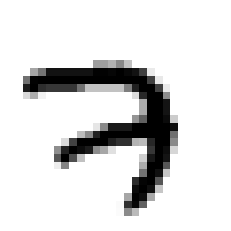

In [110]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [111]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [112]:
X_valid.shape

(5000, 28, 28)

In [113]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

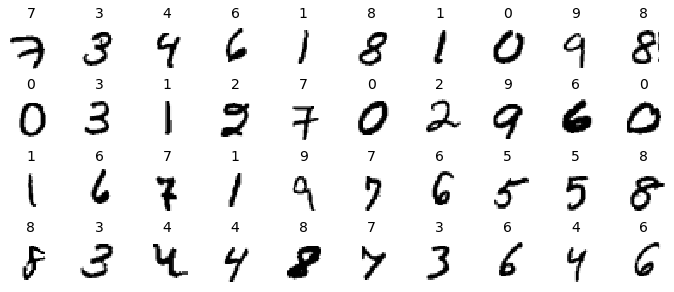

In [114]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [115]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [116]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [117]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [118]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [119]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.5843 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

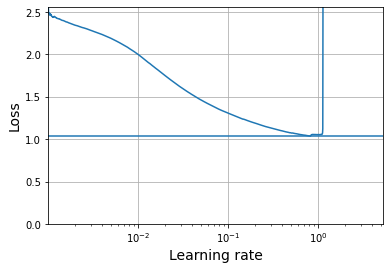

In [120]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [121]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [122]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [123]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [124]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [125]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2363 - accuracy: 0.9264 - val_loss: 0.0972 - val_accuracy: 0.9720
Epoch 2/100
1719/1719 [==============================] - 2s 997us/step - loss: 0.0948 - accuracy: 0.9702 - val_loss: 0.1035 - val_accuracy: 0.9706
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0667 - accuracy: 0.9792 - val_loss: 0.0783 - val_accuracy: 0.9770
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0463 - accuracy: 0.9848 - val_loss: 0.0827 - val_accuracy: 0.9766
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0359 - accuracy: 0.9881 - val_loss: 0.0698 - val_accuracy: 0.9826
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.1048 - val_accuracy: 0.9758
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0245 - accuracy: 0.9917 - val_loss: 0.0932 - val_

In [126]:
model = tf.keras.models.load_model("my_mnist_model") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 908us/step - loss: 0.0708 - accuracy: 0.9799


[0.07079131156206131, 0.9799000024795532]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [127]:
%tensorboard --logdir=./my_mnist_logs